# Исследование данных о фильмах (**CIMO**)

In [ ]:
%pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import ijson
import csv
import json
import tarfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
from collections import Counter

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Предобработка

### Что нужно сделать?
- Разобрать `JSON-файлы` с информацией о фильмах и людях, используя потоковую обработку;
- Отфильтровать нужные данные;
- Преобразовать данные и сохранить их временно в формат `pickle`;

### Используемые технологии:
- `pandas` для работы с таблицами;
- `ijson` для потоковой работы с большими JSON-файлами;
- `pickle` для временного сохранения обработанных данных;

В результате у нас должен получиться структурированный набор данных, готовый для дальнейшего анализа.

### Разбор JSON-файлов с информацией о фильмах и людях

#### 📌 Table: `people`
| Column    | Type  | Properties |
|-----------|-------|------------|
| id        | int   | PK         |
| name      | str   | not-null   |
| photo_url | str   |            |

---

#### 🎬 Table: `movies`
| Column           | Type      | Properties |
|------------------|-----------|------------|
| id               | int       | PK         |
| type             | enum      | not-null   |
| name             | str       | not-null   |
| release_year     | int       | not-null   |
| description      | text      |            |
| rating_kp        | float     |            |
| rating_imdb      | float     |            |
| runtime          | int       |            |
| age_rating       | int       |            |
| poster_url       | str       | not-null   |
| genres           | list[str] |            |
| countries        | list[str] |            |

---

#### 🎭 Table: `movie_roles`
| Column     | Type                       | Properties |
|------------|----------------------------|------------|
| movie_id   | int                        | FK, PK     |
| person_id  | int                        | FK, PK     |
| priority   | int                        | not-null   |
| role       | enum                       | not-null   |


In [ ]:
# После монтирования google диска вытащим данные из архива

archive_path = "/content/drive/MyDrive/kinopoisk_datasets.tar.xz"
extract_path = "/content/kinopoisk_datasets"
os.makedirs(extract_path, exist_ok=True)

with tarfile.open(archive_path, "r:xz") as tar:
    tar.extractall(path=extract_path)

In [ ]:
old_name = "/content/kinopoisk_datasets/mnt/data/2025_02_25"
new_name = "/content/kinopoisk_datasets/mnt/data/jsons"
os.rename(old_name, new_name)

##### Вытащим необходимые столбцы из `movies.json`

In [ ]:
movies_path = "/content/kinopoisk_datasets/mnt/data/jsons/movies.json"
columns = ["id", "type", "name", "release_year", "description",
           "short_description", "rating_kp", "rating_imdb",
           "runtime", "age_rating", "poster_url", "genres",
           "countries", "people"]


with open(movies_path, "r", encoding="utf-8") as file_json:
    with open("movies_temp.csv", "w", newline="", encoding="utf-8") as csv_file:
        # Используем ijson для потоковой обработки JSON
        objects = ijson.items(file_json, "item")

        csv_writer = csv.DictWriter(csv_file, fieldnames=columns)
        csv_writer.writeheader()

        for obj in objects:
            if not obj: continue

            # Хотим оставить только фильмы, мультфильмы и аниме
            if obj.get('type') not in ['movie', 'cartoon', 'anime']: continue

            row = dict.fromkeys(columns)
            row['id'] = obj.get('id')
            row['type'] = obj.get('type').upper()
            row['name'] = obj.get('name')
            row['release_year'] = obj.get('year')
            row['description'] = obj.get('description')
            row['short_description'] = obj.get('shortDescription')

            # Рейтинги (могут отсутствовать)
            if obj.get('rating'):
                row['rating_kp'] = obj.get('rating', {}).get('kp')
                row['rating_imdb'] = obj.get('rating', {}).get('imdb')

            row['runtime'] = obj.get('movieLength')
            row['age_rating'] = obj.get('ageRating')

            # URL постера (может отсутствовать)
            if obj.get('poster'):
                row['poster_url'] = obj.get('poster', {}).get('url')

            # Жанры (конвертируем список словарей в строку с разделителем `#`)
            if obj.get('genres'):
                genres = "#".join(genre.get('name') for genre in obj.get('genres', []))
                row['genres'] = genres if genres else None

            # Страны (аналогично жанрам)
            if obj.get('countries'):
                countries = "#".join(country.get('name') for country in obj.get('countries', []))
                row['countries'] = countries if countries else None

            # Люди (ID и профессия) - необходимо для дальнейшего маппинга
            if obj.get('persons'):
                persons = [f"{p.get('id')}&{p.get('profession')}" for p in obj.get('persons', [])]
                persons = "#".join(persons)
                row['people'] = persons if persons else None

            csv_writer.writerow(row)


##### Вытащим необходимые столбцы из `people.json`

In [ ]:
people_path = "/content/kinopoisk_datasets/mnt/data/jsons/people.json"
columns = ["id", "name", "photo_url"]


with open(people_path, 'r', encoding='utf-8') as file_json:
    with open("people_temp.csv", 'w', newline='', encoding='utf-8') as csv_file:
        # Используем ijson для потоковой обработки JSON-файла
        objects = ijson.items(file_json, "item")

        csv_writer = csv.DictWriter(csv_file, fieldnames=columns)
        csv_writer.writeheader()

        for obj in objects:
            if not obj: continue

            row = dict.fromkeys(columns)
            row['id'] = obj.get('id')  # ID человека
            name = obj.get('name')
            row['name'] = name if name is not None else obj.get('enName') # Имя человека
            row['photo_url'] = obj.get('photo')  # URL фото

            csv_writer.writerow(row)

### Фильтрация файла с фильмами

In [ ]:
movies_df = pd.read_csv("movies_temp.csv")
movies_df.head()

,id,type,name,release_year,description,short_description,rating_kp,rating_imdb,runtime,age_rating,poster_url,genres,countries,people
0,44168,MOVIE,Девчата,1962.0,В сибирский поселок приехала юная повариха Тос...,Юная повариха привносит жизни в маленький сиби...,8.482,7.8,92.0,0.0,https://image.openmoviedb.com/kinopoisk-images...,мелодрама#комедия,СССР,313583&актеры#284613&актеры#277614&актеры#3104...
1,1245524,MOVIE,Зависнуть в Палм-Спрингс,2020.0,9 ноября неподалёку от Палм-Спрингс идёт подго...,Бездельник и сестра невесты застревают в празд...,7.312,7.4,90.0,18.0,https://image.openmoviedb.com/kinopoisk-images...,комедия#мелодрама#фантастика,США#Гонконг,1108501&актеры#1098850&актеры#8552&актеры#1395...
2,666,MOVIE,Форсаж,2001.0,"Его зовут Брайан, и он — фанат турбин и нитроу...",Коп под прикрытием внедряется в банду стритрей...,7.823,6.8,106.0,18.0,https://image.openmoviedb.com/kinopoisk-images...,боевик#триллер#криминал,США#Германия,6317&актеры#11437&актеры#2318&актеры#47679&акт...
3,5101781,CARTOON,Иван Царевич и Серый Волк 5,2022.0,"Была у Ивана с Василисой не жизнь, а сказка. Б...",Одно беспечное путешествие в прошлое — и Ивана...,7.446,0.0,78.0,6.0,https://image.openmoviedb.com/kinopoisk-images...,мультфильм#приключения#семейный,Россия,1625289&актеры#566951&актеры#238512&актеры#272...
4,965754,MOVIE,Дело храбрых,2017.0,История о команде пожарных под названием Grani...,Пожарные пытаются остановить стихию в лесах Ар...,8.259,7.6,134.0,18.0,https://image.openmoviedb.com/kinopoisk-images...,драма#триллер#биография#история,США,14668&актеры#1669945&актеры#6652&актеры#6966&а...


In [ ]:
movies_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989227 entries, 0 to 989226
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 989227 non-null  int64  
 1   type               989227 non-null  object 
 2   name               262286 non-null  object 
 3   release_year       935434 non-null  float64
 4   description        153324 non-null  object 
 5   short_description  18306 non-null   object 
 6   rating_kp          989227 non-null  float64
 7   rating_imdb        989227 non-null  float64
 8   runtime            672193 non-null  float64
 9   age_rating         83933 non-null   float64
 10  poster_url         256379 non-null  object 
 11  genres             949019 non-null  object 
 12  countries          970579 non-null  object 
 13  people             981355 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 105.7+ MB


In [ ]:
# Берём фильмы только с русскими названиями
movies_df = movies_df[(movies_df['name'].isna() == False)]

# Для пользователей нет смысла показывать фильмы, у которых дата выхода nan или > 2025
# Преобразуем столбец к int64
movies_df = movies_df[(movies_df['release_year'].isna() == False) & (movies_df['release_year'] <= 2025)]
movies_df['release_year'] = movies_df['release_year'].astype('int64')

# Удалим столбец short_description, так как значений << чем фильмов
movies_df.drop(columns=['short_description'], inplace=True)

# Преобразуем столбцы с рейтингами так, чтобы 0.0 обозначало отсутствие оценки + округлим значения
movies_df['rating_kp'] = movies_df['rating_kp'].replace(0.0, np.nan)
movies_df['rating_imdb'] = movies_df['rating_imdb'].replace(0.0, np.nan)
movies_df['rating_kp'] = movies_df['rating_kp'].round(1)
movies_df['rating_imdb'] = movies_df['rating_imdb'].round(1)

# Уберем фильмы, длина которых запредельна мала или запредельна велика (средняя длина - 90 мин, с разбросом +- 50 мин)
# Однако стоит учесть, что верхняя оценка не так проста, поэтому возьмём её побольше
movies_df = movies_df[movies_df['runtime'].isna() | (movies_df['runtime'] >= 40) & (movies_df['runtime'] <= 300)]

# Уберём фильмы без постеров + удалим общую часть URL-адреса
movies_df = movies_df[(movies_df['poster_url'].isna() == False)]
mcommon_prefix = "https://image.openmoviedb.com/kinopoisk-images"
movies_df = movies_df[movies_df['poster_url'].str.startswith(mcommon_prefix)]
movies_df['poster_url'] = movies_df['poster_url'].str.replace(mcommon_prefix, '', regex=False)

# Преобразуем жанры и страны в списки
movies_df['genres'] = movies_df['genres'].str.split('#')
movies_df['countries'] = movies_df['countries'].str.split('#')

# Преобразуем людей в списки кортежей для формирования другой таблицы
def parse_people(people_str):
    if people_str is np.nan: return np.nan
    tuples = [tuple(pair.split('&')) for pair in people_str.split('#')]
    return [t for t in tuples if t[-1] in ('актеры', 'режиссеры')]

movies_df['people'] = movies_df['people'].apply(parse_people)

In [ ]:
movies_df.head()

,id,type,name,release_year,description,rating_kp,rating_imdb,runtime,age_rating,poster_url,genres,countries,people
0,44168,MOVIE,Девчата,1962,В сибирский поселок приехала юная повариха Тос...,8.5,7.8,92.0,0.0,/4303601/d5ee73ae-82af-4f60-af5e-f080bed523d8/...,"[мелодрама, комедия]",[СССР],"[(313583, актеры), (284613, актеры), (277614, ..."
1,1245524,MOVIE,Зависнуть в Палм-Спрингс,2020,9 ноября неподалёку от Палм-Спрингс идёт подго...,7.3,7.4,90.0,18.0,/1898899/b1ed53cd-002f-419b-89bf-1eb66507f6de/...,"[комедия, мелодрама, фантастика]","[США, Гонконг]","[(1108501, актеры), (1098850, актеры), (8552, ..."
2,666,MOVIE,Форсаж,2001,"Его зовут Брайан, и он — фанат турбин и нитроу...",7.8,6.8,106.0,18.0,/6201401/8277905e-aa09-465d-b0de-7c389a42f215/...,"[боевик, триллер, криминал]","[США, Германия]","[(6317, актеры), (11437, актеры), (2318, актер..."
3,5101781,CARTOON,Иван Царевич и Серый Волк 5,2022,"Была у Ивана с Василисой не жизнь, а сказка. Б...",7.4,NaN,78.0,6.0,/6201401/36116ce0-2960-4713-9410-8e41055c7b1c/...,"[мультфильм, приключения, семейный]",[Россия],"[(1625289, актеры), (566951, актеры), (238512,..."
4,965754,MOVIE,Дело храбрых,2017,История о команде пожарных под названием Grani...,8.3,7.6,134.0,18.0,/1946459/946e69f2-80eb-41c1-b1cd-695a4644be55/...,"[драма, триллер, биография, история]",[США],"[(14668, актеры), (1669945, актеры), (6652, ак..."


In [ ]:
movies_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 163964 entries, 0 to 989204
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            163964 non-null  int64  
 1   type          163964 non-null  object 
 2   name          163964 non-null  object 
 3   release_year  163964 non-null  int64  
 4   description   117299 non-null  object 
 5   rating_kp     64601 non-null   float64
 6   rating_imdb   147278 non-null  float64
 7   runtime       153472 non-null  float64
 8   age_rating    53480 non-null   float64
 9   poster_url    163964 non-null  object 
 10  genres        162176 non-null  object 
 11  countries     163650 non-null  object 
 12  people        163518 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 17.5+ MB


### Фильтрация файла с людьми

In [ ]:
people_df = pd.read_csv("people_temp.csv")
people_df.head()

,id,name,photo_url
0,41644,Омар Си,https://avatars.mds.yandex.net/get-kinopoisk-i...
1,57174,Анн Ле Ни,https://avatars.mds.yandex.net/get-kinopoisk-i...
2,868557,Одри Флёро,https://avatars.mds.yandex.net/get-kinopoisk-i...
3,541041,Жозефин де Мо,https://avatars.mds.yandex.net/get-kinopoisk-i...
4,964574,Альба Гайя Крагеде Беллуджи,https://avatars.mds.yandex.net/get-kinopoisk-i...


In [ ]:
people_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909050 entries, 0 to 5909049
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   id         5909050 non-null  int64 
 1   name       5908835 non-null  object
 2   photo_url  425401 non-null   object
dtypes: int64(1), object(2)
memory usage: 135.2+ MB


In [ ]:
# Оставляем среди людей тех, кто есть в отфильтрованных фильмах
all_people_ids = set()
for movie in movies_df['people']:
    if movie is np.nan: continue
    all_people_ids.update([int(id) for id, _ in movie])

people_df = people_df[people_df['id'].isin(all_people_ids)]

# Удаляем людей без имён и с подписью "Аноним"
people_df = people_df[people_df['name'].notna()]
people_df = people_df[~people_df['name'].str.contains("Аноним", na=False, case=False)]

# Уберём у всех фоток общую часть URL-адреса
pcommon_prefix = "https://avatars.mds.yandex.net/get-kinopoisk-image"
people_df['photo_url'] = people_df['photo_url'].str.replace(f"https:{pcommon_prefix}", pcommon_prefix, regex=False)
people_df['photo_url'] = people_df['photo_url'].str.replace(pcommon_prefix, '', regex=False)

def filter_people(id_prof):
    if id_prof is np.nan: return np.nan
    result = [(id, prof) for id, prof in id_prof if int(id) in valid_people_ids]
    return result if len(result) > 0 else np.nan

# Удаляем соотвествующие кортежи из таблицы с фильмами
valid_people_ids = set(people_df['id'])
movies_df['people'] = movies_df['people'].apply(filter_people)


In [ ]:
people_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1344377 entries, 0 to 5909049
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   id         1344377 non-null  int64 
 1   name       1344377 non-null  object
 2   photo_url  285483 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.0+ MB


In [ ]:
movies_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 163964 entries, 0 to 989204
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            163964 non-null  int64  
 1   type          163964 non-null  object 
 2   name          163964 non-null  object 
 3   release_year  163964 non-null  int64  
 4   description   117299 non-null  object 
 5   rating_kp     64601 non-null   float64
 6   rating_imdb   147278 non-null  float64
 7   runtime       153472 non-null  float64
 8   age_rating    53480 non-null   float64
 9   poster_url    163964 non-null  object 
 10  genres        162176 non-null  object 
 11  countries     163650 non-null  object 
 12  people        163364 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 17.5+ MB


### Итоговый вид

In [ ]:
people_df.head()

,id,name,photo_url
0,41644,Омар Си,/1777765/6ff214c8-e427-4dc2-b447-a1a51743c3ff/...
1,57174,Анн Ле Ни,/1704946/5a5a2bdf-6e96-47ed-9675-cb42c1712d3c/...
2,868557,Одри Флёро,/1777765/8cff3d96-7dd6-487b-a9df-537ff056e375/...
3,541041,Жозефин де Мо,/1777765/726cdd85-f2ca-4ff7-b7ee-5c28db8d1139/...
4,964574,Альба Гайя Крагеде Беллуджи,/4774061/8e98010f-0814-45e9-8c8a-6d9c968e412c/...


In [ ]:
movies_df.head()

,id,type,name,release_year,description,rating_kp,rating_imdb,runtime,age_rating,poster_url,genres,countries,people
0,44168,MOVIE,Девчата,1962,В сибирский поселок приехала юная повариха Тос...,8.5,7.8,92.0,0.0,/4303601/d5ee73ae-82af-4f60-af5e-f080bed523d8/...,"[мелодрама, комедия]",[СССР],"[(313583, актеры), (284613, актеры), (277614, ..."
1,1245524,MOVIE,Зависнуть в Палм-Спрингс,2020,9 ноября неподалёку от Палм-Спрингс идёт подго...,7.3,7.4,90.0,18.0,/1898899/b1ed53cd-002f-419b-89bf-1eb66507f6de/...,"[комедия, мелодрама, фантастика]","[США, Гонконг]","[(1108501, актеры), (1098850, актеры), (8552, ..."
2,666,MOVIE,Форсаж,2001,"Его зовут Брайан, и он — фанат турбин и нитроу...",7.8,6.8,106.0,18.0,/6201401/8277905e-aa09-465d-b0de-7c389a42f215/...,"[боевик, триллер, криминал]","[США, Германия]","[(6317, актеры), (11437, актеры), (2318, актер..."
3,5101781,CARTOON,Иван Царевич и Серый Волк 5,2022,"Была у Ивана с Василисой не жизнь, а сказка. Б...",7.4,NaN,78.0,6.0,/6201401/36116ce0-2960-4713-9410-8e41055c7b1c/...,"[мультфильм, приключения, семейный]",[Россия],"[(1625289, актеры), (566951, актеры), (238512,..."
4,965754,MOVIE,Дело храбрых,2017,История о команде пожарных под названием Grani...,8.3,7.6,134.0,18.0,/1946459/946e69f2-80eb-41c1-b1cd-695a4644be55/...,"[драма, триллер, биография, история]",[США],"[(14668, актеры), (1669945, актеры), (6652, ак..."


In [ ]:
# # Сохранение таблиц в формат pickle
movies_df.to_pickle("movies.pkl")
people_df.to_pickle("people.pkl")

# # Сохранение на google диск
!mkdir /content/drive/MyDrive/processed_dataset/
!cp movies.pkl /content/drive/MyDrive/processed_dataset/
!cp people.pkl /content/drive/MyDrive/processed_dataset/

## Статистический анализ данных

In [ ]:
common_url = "/content/drive/MyDrive/processed_dataset"

movies_df = pd.read_pickle(f"{common_url}/movies.pkl")
people_df = pd.read_pickle(f"{common_url}/people.pkl")

In [ ]:
movies_df.shape

(163964, 13)

In [ ]:
# id, people - столбцы для маппинга и создания таблицы-связки
movies_df.columns

Index(['id', 'type', 'name', 'release_year', 'description', 'rating_kp',
       'rating_imdb', 'runtime', 'age_rating', 'poster_url', 'genres',
       'countries', 'people'],
      dtype='object')

### Распределение фильмов по различным столбцам

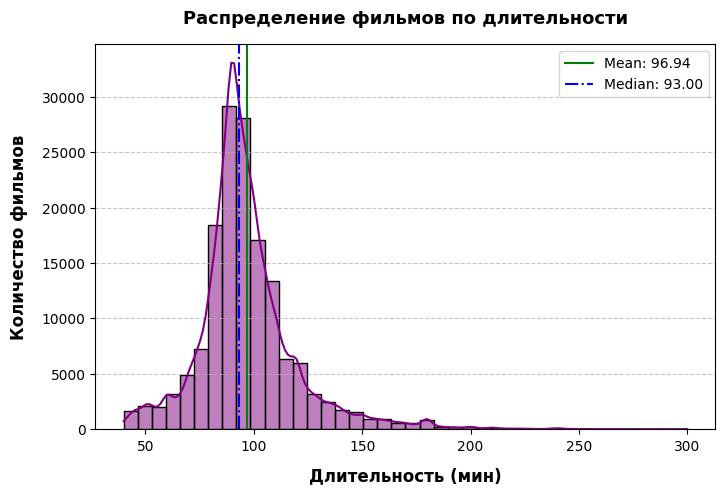

In [ ]:
runtime_not_null = movies_df[movies_df['runtime'].notnull()]['runtime']
mean_value = np.mean(runtime_not_null)
median_value = np.median(runtime_not_null)

plt.figure(figsize=(8, 5))
sns.histplot(runtime_not_null, bins=40, edgecolor='black', color='purple', kde=True)
plt.axvline(mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='-.', label=f'Median: {median_value:.2f}')
plt.xlabel('Длительность (мин)', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по длительности', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Как можно заметить на графике, среднее и медиана длительности фильмов имеют практически
# одинаковые показатели. Из этого можно сделать вывод, что значетельных выбросов в данных нет.
# Также можно заметить, что медиана и среднее близки к моде => распределение данных является унимодальным.
# Более того, мы можем утверждать, что данные имеют приближённое к симметричному/нормальному распределение.

In [ ]:
movies_df['runtime'].isnull().sum()

# Стоит отметить, что в данных находятся фильмы, у которых не проставлен параметр длительности

np.int64(10492)

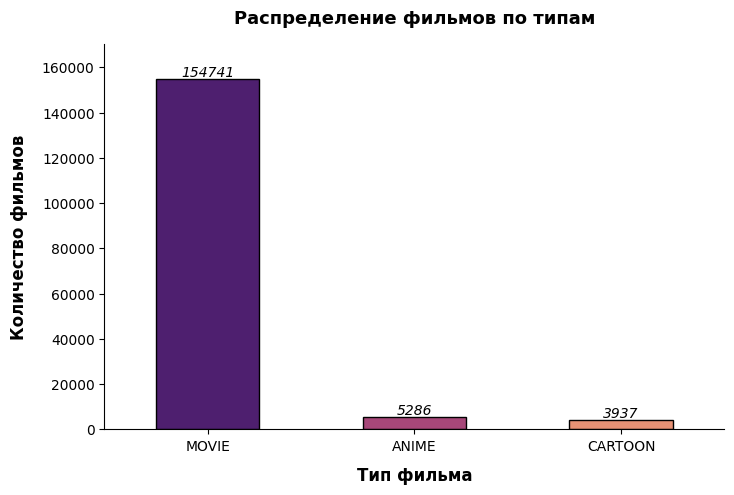

In [ ]:
type_counts = movies_df['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

plt.figure(figsize=(8, 5))
ax = sns.barplot(type_counts, x='type', y='count', palette='magma', edgecolor='black', width=0.5)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontstyle='italic')
plt.xlabel('Тип фильма', fontsize=12, fontweight='bold', labelpad=10)
plt.ylim(0, 1.1 * np.max(type_counts['count']))
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по типам', fontsize=13, fontweight='bold', pad=15)
plt.show()

# На этом графике несложно заметить, что подавляющая часть датасета занята фильмами. Но при этом мы решили
# оставить также мультфильмы и аниме, поскольку они также будут иметь спрос у части потенциальной аудитории нашего
# приложения.

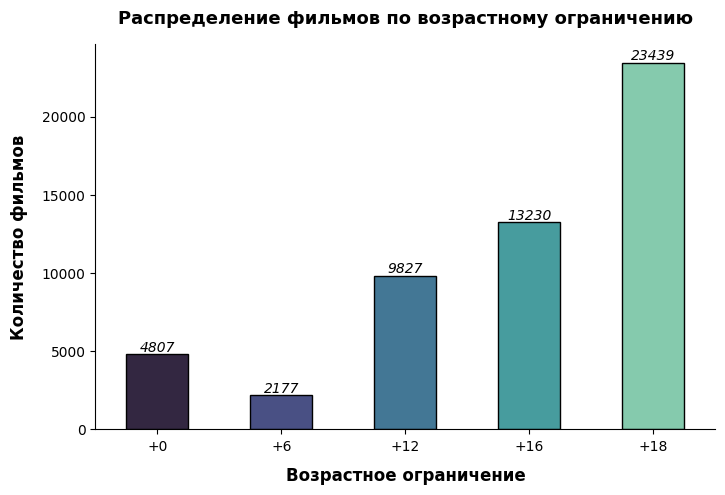

In [ ]:
age_counts = movies_df['age_rating'].value_counts().reset_index()
age_counts.columns = ['age', 'count']
age_counts.sort_values(by='age', inplace=True)
age_counts['age'] = age_counts['age'].astype(int).map(lambda x: f"+{int(x)}")

plt.figure(figsize=(8, 5))
ax = sns.barplot(age_counts, x='age', y='count', palette='mako', edgecolor='black', width=0.5)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontstyle='italic')
plt.xlabel('Возрастное ограничение', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по возрастному ограничению', fontsize=13, fontweight='bold', pad=15)
plt.show()

# Возрастные ограничения можно разделить на три группы: детские (от 0 до 12), подростковые (от 12 до 16) и взрослые
# (от 16 лет). Как можно заметить, большинство фильмов в датасете попадают под взрослую аудиторию, что означает,
# что наиболее яркие и детальные рекомендации мы сможем предоставить для аудитории 16+. Но при этом, большая часть
# популярных в мире франшиз стремятся попадать под категорию 12+, из чего можно сделать вывод, что именно с этой
# категории начинаются самые востребованные фильмы у аудитории.

In [ ]:
movies_df['age_rating'].isnull().sum()

# Однако стоит отметить, что 2/3 фильмов не имеют значение в столбце age_rating, что
# может означать, что среди них есть старые фильмы, не прошедшие официальную сертификацию
# и образовательные и документательные фильмы

np.int64(110484)

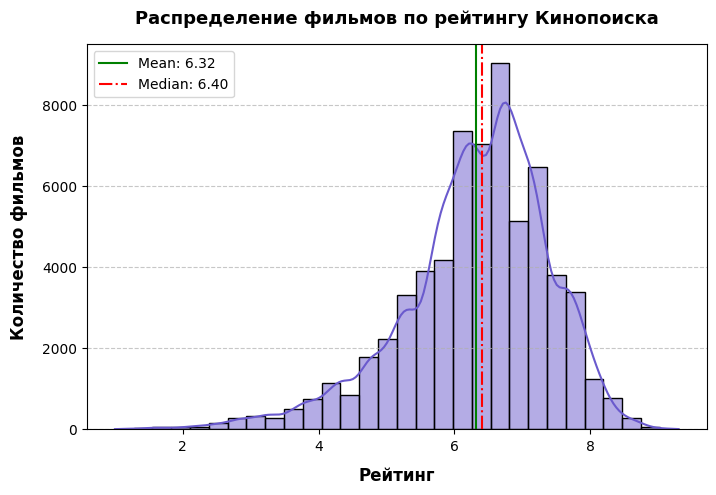

In [ ]:
kp_not_null = movies_df[movies_df['rating_kp'].notnull()]['rating_kp']
mean_value = np.mean(kp_not_null)
median_value = np.median(kp_not_null)

plt.figure(figsize=(8, 5))
sns.histplot(kp_not_null, bins=30, edgecolor='black', color='slateblue', kde=True)
plt.axvline(mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='red', linestyle='-.', label=f'Median: {median_value:.2f}')
plt.xlabel('Рейтинг', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по рейтингу Кинопоиска', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()

# На этом графике, отображающем распределение фильмов по средней оценке на Кинопоиске, мы можем наблюдать, что среднее и
# медиана практически совпадают и близки к моде => распределение данных приближено к нормальному, в данных отсутствуют значительные
# выбросы. Около 9000 фильмов имеют оценку ~6,6-6,8, что является модой в нашей выборке. Интересно, что
# график оценок от 3 до 4 и от 8 до 9 практически симметричен, соответственно количество таких фильмов примерно одинаково.

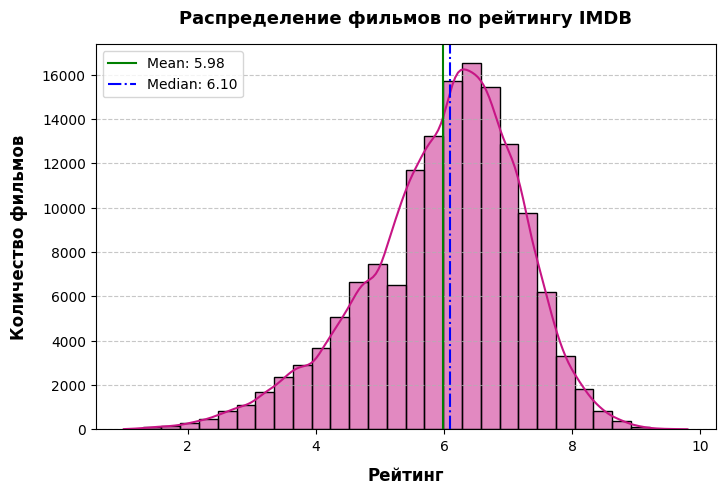

In [ ]:
imdb_not_null = movies_df[movies_df['rating_imdb'].notnull()]['rating_imdb']
mean_value = np.mean(imdb_not_null)
median_value = np.median(imdb_not_null)

plt.figure(figsize=(8, 5))
sns.histplot(imdb_not_null, bins=30, edgecolor='black', color='mediumvioletred', kde=True)
plt.axvline(mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='-.', label=f'Median: {median_value:.2f}')
plt.xlabel('Рейтинг', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по рейтингу IMDB', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.show()

# Этот график схож с предыдущим по распределению оценок, но имеет гораздо большую выборку оцененных фильмов.
# Это обусловлено тем, что IMDB - международный сервис, и имеет более широкую выборку фильмов.
# Также можно заметить, что среднее и медиана отличаются от значений рейтингов Кинопоиска почти на 0,5 балла.
# Этот факт также проистекает из умозаключения о большей выборке IMDB, поскольку чем больше данных, тем больше
# среднее и медиана подвержены колебанию.

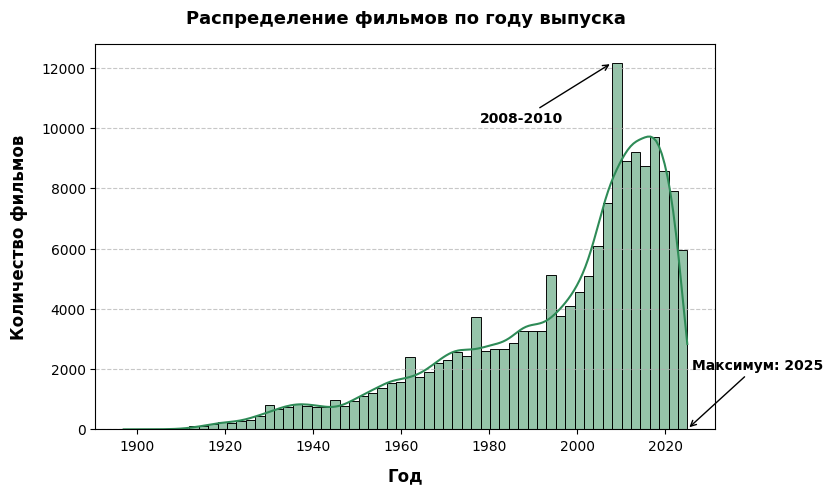

In [ ]:
plt.figure(figsize=(8, 5))
hist = sns.histplot(movies_df['release_year'], bins=60, edgecolor='black', color='seagreen', kde=True)

max_year = movies_df['release_year'].max()
plt.annotate(f"Максимум: {max_year}",
            xy=(max_year, 10),
            xytext=(max_year + 1, 2000),
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=10, fontweight='bold')

counts, bin_edges = np.histogram(movies_df['release_year'], bins=60)
max_count_index = counts.argmax()
max_bin_left_edge = bin_edges[max_count_index]
max_bin_height = counts[max_count_index]
plt.annotate(f'{max_bin_left_edge:.0f}-{max_bin_left_edge + 2:.0f}',
             xy=(max_bin_left_edge, max_bin_height),
             xytext=(max_bin_left_edge - 30, max_bin_height - 2000),
             arrowprops=dict(facecolor='blue', arrowstyle='->'),
             fontsize=10, fontweight='bold')

plt.xlabel('Год', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по году выпуска', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Можно заметить, что с каждым годом количество выпускаемых фильмов постепенно увеличивается. На графике мы можем
# заметить, что каждые 20 лет в индустрии кинопроизводства на отрезке в 1-2 года происходит всплеск выпуска фильмов,
# что выбивается из общего тренда. Наиболее яркий всплеск - 2008-2010 годы. Это обусловлено несколькими причинами.
# Во-первых, именно в этот временной период произошел массовый переход от плёнки к цифровому кинопроизводству, что
# упростило процесс производства фильмов. Во-вторых, именно тогда начался взлёт стриминговых сервисов. В-третьих,
# увеличилось производство фильмов в Китае, Индии и Южной Корее, именно в этот период китайский рынок стал вторым
# в мире после США.

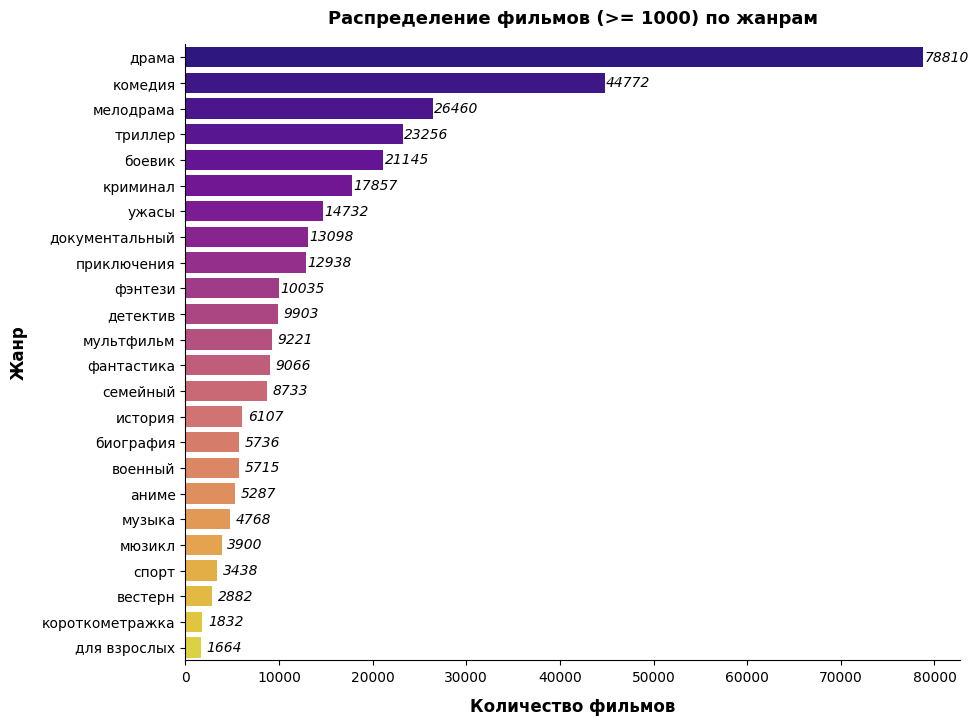

In [ ]:
all_genres = [genre for sublist in movies_df['genres'].dropna() for genre in sublist]
genre_counts = Counter(all_genres)
genre_counts = {k: v for k, v in genre_counts.items() if v >= 1000}
genre_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(genre_df, x='count', y='genre', palette='plasma', width=0.8)
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_x() + p.get_width() + 2500, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, fontstyle='italic')
sns.despine()
plt.xlabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Жанр', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов (>= 1000) по жанрам', fontsize=13, fontweight='bold', pad=15)
plt.show()

# Подавляющее большинство фильмов сконцентрировано в жанре `драма` и `комедия`, что означает постоянную востребованность
# фильмов данных жанров в киноиндустрии. Чуть меньшее количество выпущенных фильмов (от 20000) имеют жанры `мелодрама`,
# `триллер`, `боевик`. Также стоит отметить `фэнтези`, `приключения`, `документальные фильмы`, `ужасы` и `криминал`.
# Именно вокруг этих жанров будут строится наши рекомендации в силу их востребованности.

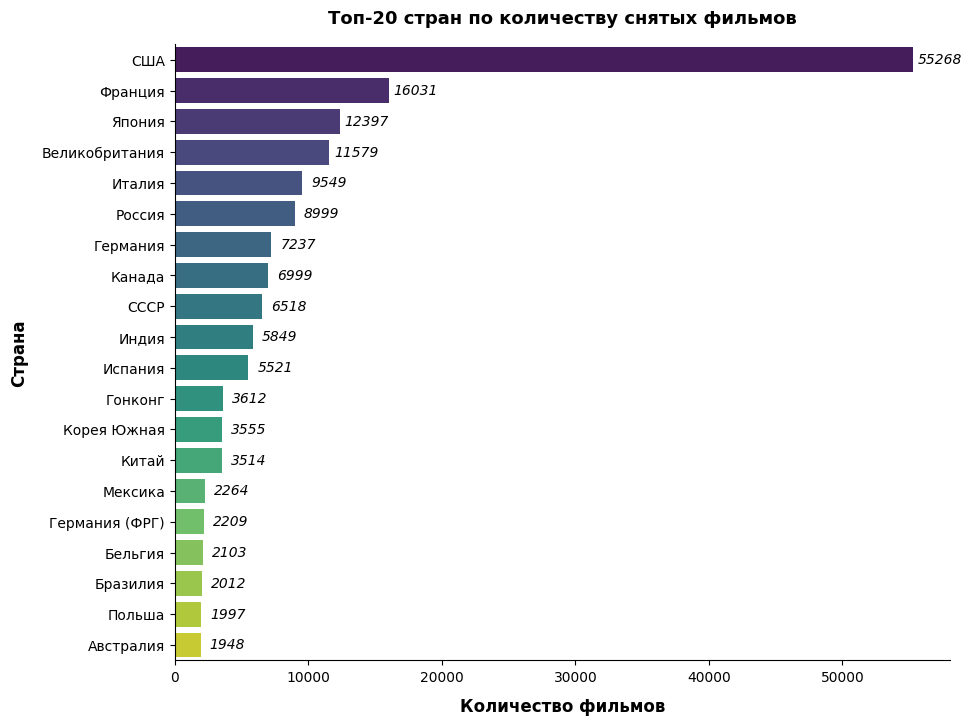

In [ ]:
all_countries = [country for sublist in movies_df['countries'].dropna() for country in sublist]
country_counts = Counter(all_countries)
country_df = pd.DataFrame(country_counts.items(), columns=['country', 'count']).sort_values(by='count', ascending=False)
top_countries = country_df.head(20)

plt.figure(figsize=(10, 8))
ax = sns.barplot(top_countries, x='count', y='country', palette='viridis', width=0.8)
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_x() + p.get_width() + 2000, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, fontstyle='italic')
sns.despine()
plt.xlabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Страна', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Топ-20 стран по количеству снятых фильмов', fontsize=13, fontweight='bold', pad=15)
plt.show()

# Стоит отметить, что данные в датасете чуть разнятся с реальностью, но это обусловленно важным фактом.
# Топ-3 стран по количеству выпущенных фильмов: Индия, Нигерия и США. Как можно заметить, наш датасет включает большое
# количество фильмов из США, а Нигерия даже не представлена в топ-20. Объяснить это можно тем, что фильмы, выпущенные в
# Китае, Индии, Нигерии и других, отличных от нашей культуры стран, не востребованы в СНГ сегменте. Соответственно можно
# сделать вывод, что для наиболее качественных рекомендаций фильмы такого производства должны быть представлены в нашем
# датасете в небольшом количестве.

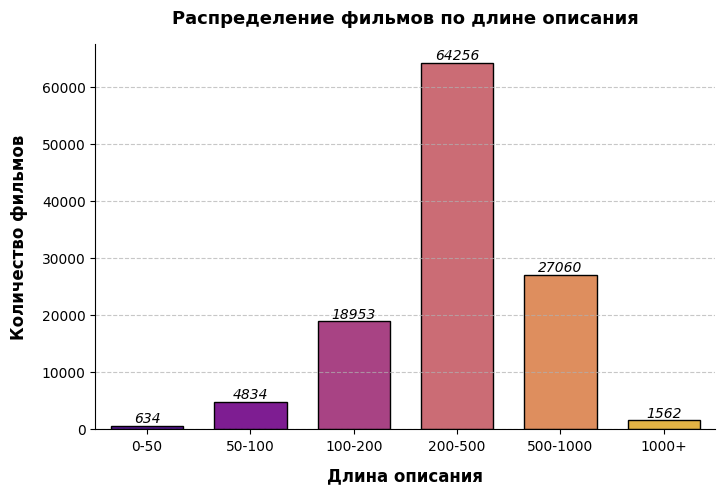

In [ ]:
movies_df['description_len'] = movies_df['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)

bins = [0, 50, 100, 200, 500, 1000, float('inf')]
labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']
movies_df['description_len_bin'] = pd.cut(movies_df['description_len'], bins=bins, labels=labels, right=False)
agg_data = movies_df.groupby('description_len_bin').agg(movie_count=('description', 'count')).reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(agg_data, x='description_len_bin', y='movie_count', palette='plasma', edgecolor='black', width=0.7)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontstyle='italic')

plt.xlabel('Длина описания', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Количество фильмов', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Распределение фильмов по длине описания', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Здесь мы можем заметить, что большинство фильмов имеют описание в 200-500 символов, соответсвенно такая длина описания
# является наиболее достаточной для передачи зрителю информации о фильме. Это является важным
# маркером для проектирования карточки фильма в нашем проекте. Также стоит заметить, что 1562 фильма имеют описание более
# чем на 1000 символов. Ниже мы вывели фильмы с наиболее длинным описанием.

In [ ]:
long_description_movies = movies_df[movies_df['description_len'] >= 2000]
long_description_movies.sort_values(by='description_len', ascending=False)[['name', 'description_len']]

# Как можно заметить, фильмы со столь длинным описанием не известны широкой публике. Соответсвенно можем задуматься,
# насколько нам нужны фильмы с таким объёмным описанием и нужно ли нам их убрать.

,name,description_len
212664,Для начинающих любить,2909
210384,Кто убил электрокар?,2799
15574,Запретные темы истории: Неизвестная Мексика,2723
9395,Калейдоскоп ужасов,2709
909083,Все о выращивании цветов в вашем саду: Однолет...,2274
21654,Ты – моя жизнь,2271
934942,Шанк пракшалана — йога для очищения организма,2127
579223,Последняя командировка,2059
181479,Олимпийская деревня,2028


### Зависимости различных столбцов друг от друга

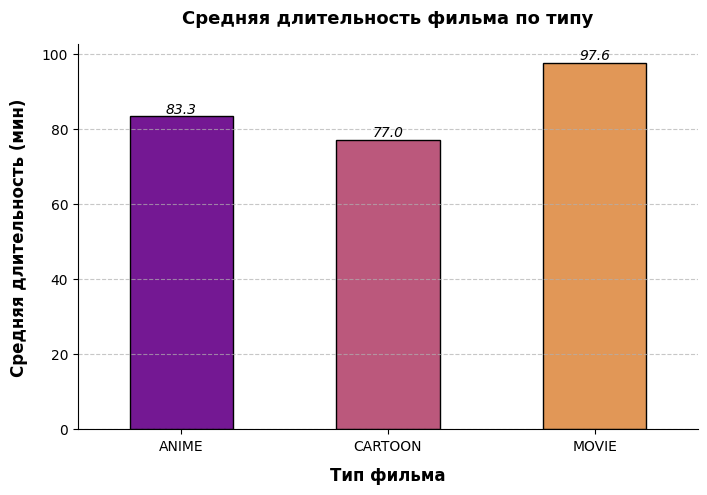

In [ ]:
runtime_mean = movies_df.groupby('type')['runtime'].mean().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(runtime_mean, x='type', y='runtime', palette='plasma', edgecolor='black', width=0.5)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontstyle='italic')
plt.xlabel('Тип фильма', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Средняя длительность (мин)', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Средняя длительность фильма по типу', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Как мы могли понять ранее, средний хронометраж обычного кино составляет около 97 минут.
# Аниме и мультфильмы в среднем короче на 14 и 20 минут соответственно.

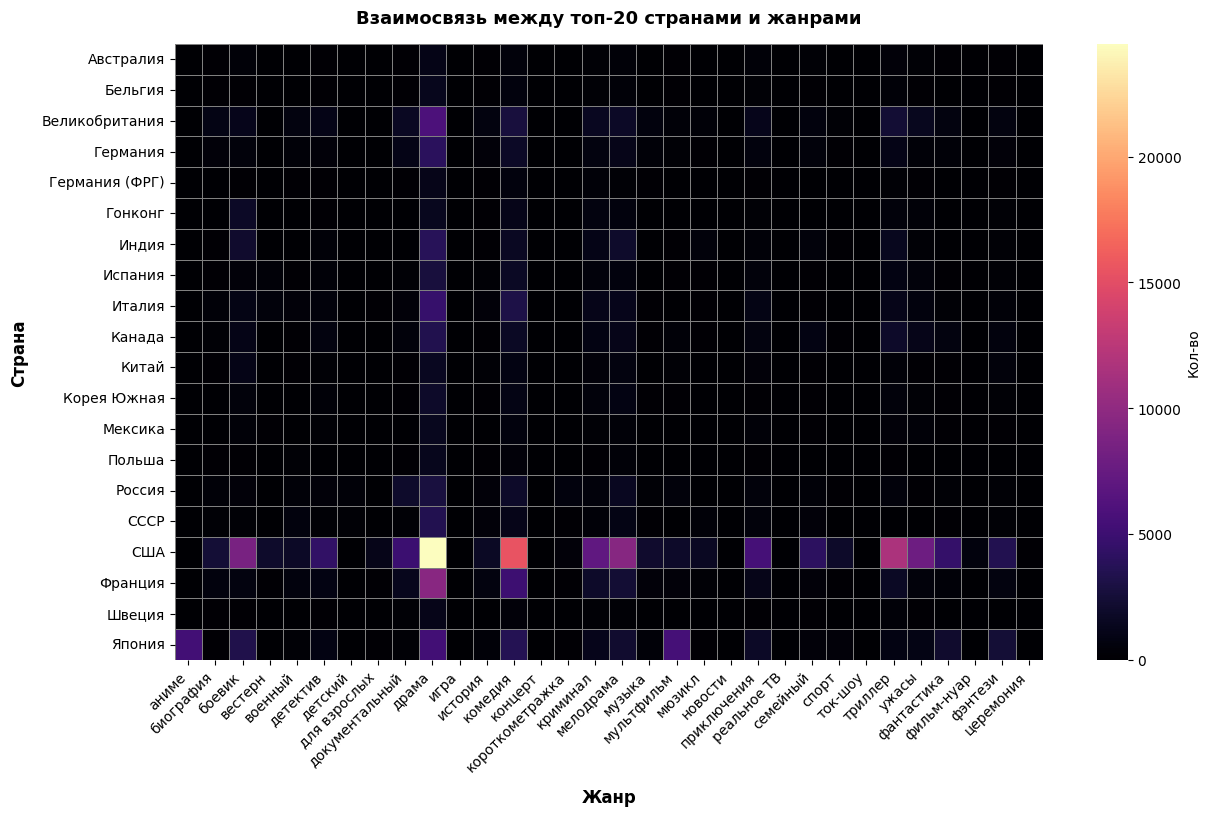

In [ ]:
country_genre_data = []

for _, row in movies_df.dropna(subset=['countries', 'genres']).iterrows():
    for country in row['countries']:
        for genre in row['genres']:
            country_genre_data.append({'country': country, 'genre': genre})

country_genre_df = pd.DataFrame(country_genre_data)
top_countries = country_genre_df['country'].value_counts().nlargest(20).index
filtered_df = country_genre_df[country_genre_df['country'].isin(top_countries)]
country_genre_pivot = filtered_df.pivot_table(index='country', columns='genre', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(country_genre_pivot, cmap='magma', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Кол-во'})
plt.xlabel('Жанр', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Страна', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Взаимосвязь между топ-20 странами и жанрами', fontsize=13, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Самый яркий сектор находится на пересечении `США` и `драмы`, что неудивительно, учитывая наши
# предыдущие графики, поскольку фильмы из США представлены в датасете в наибольшем количестве, а драма
# является самым популярным жанром. Опять же, исходя из большого количества фильмов из США, почти вся строка США
# раскрашена. Также мы можем заметить пересечения стран и их традиционных жанров. Например, пересение Японии и аниме
# даёт нам представление о том, что практически все фильмы этого жанра выпускаются в Японии.

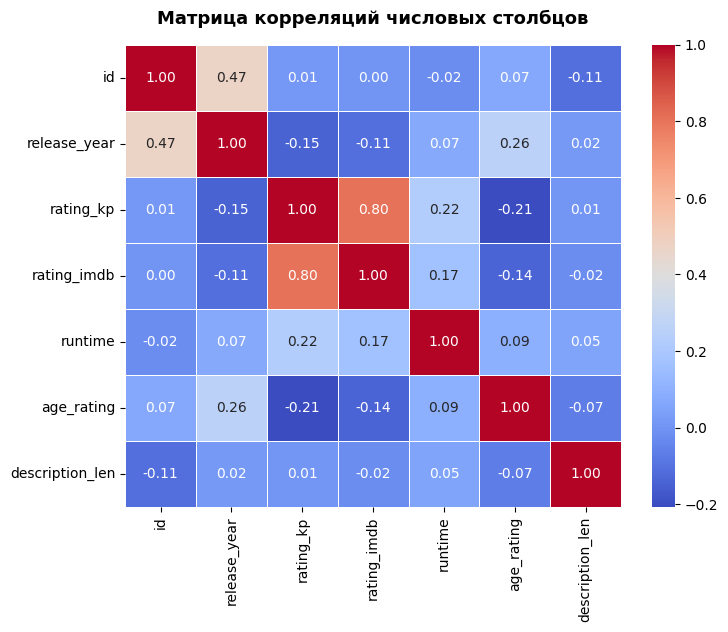

In [ ]:
correlation_matrix = movies_df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций числовых столбцов', fontsize=13, fontweight='bold', pad=15)
plt.show()

# В матрице корреляций мы можем заметить, что наиболее яркая корреляция существует между рейтингом Кинопоиска и рейтингом
# IMDB, что неудивительно, учитывая, что они отражают одни и те же признаки.

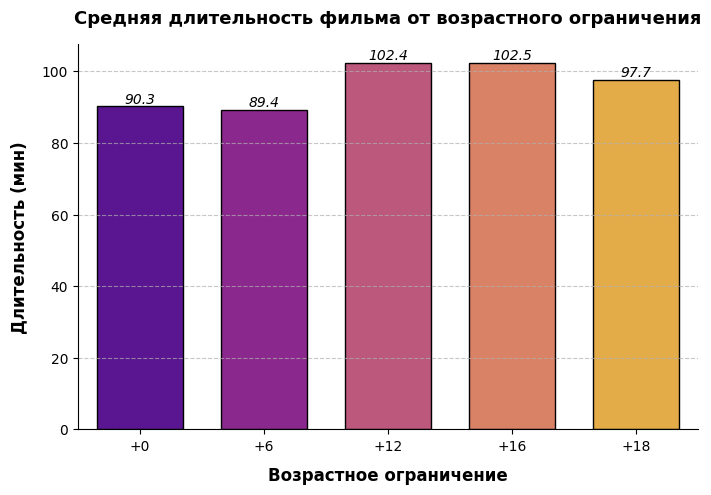

In [ ]:
runtime_mean = movies_df.groupby('age_rating')['runtime'].mean().reset_index()
runtime_mean.columns = ['age', 'runtime']
runtime_mean.sort_values(by='age', inplace=True)
runtime_mean['age'] = runtime_mean['age'].astype(int).map(lambda x: f"+{int(x)}")

plt.figure(figsize=(8, 5))
ax = sns.barplot(runtime_mean, x='age', y='runtime', palette='plasma', edgecolor='black', width=0.7)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontstyle='italic')
plt.xlabel('Возрастное ограничение', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Длительность (мин)', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Средняя длительность фильма от возрастного ограничения', fontsize=13, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Можно заметить, что фильмы с возрастным ограничением 12+ имеют примерно одинаковую продолжительность.
# Также интересно, что продолжительность фильмов с возрастным ограничением 0+ и 6+ сильно короче. Это обусловлено тем,
# что большинство фильмов с таким возрастным ограничением имеют жанр мультфильмы, а как мы выяснили ранее, они имеют
# наименьшую длительность.

------------------------------------------------------------------------------------------------

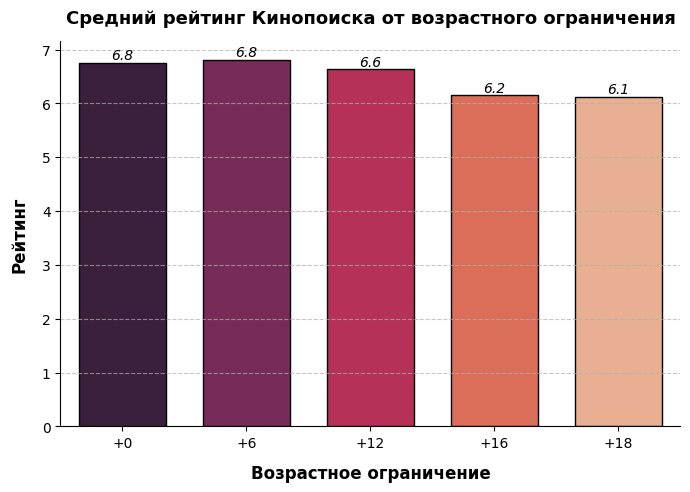

In [ ]:
kp_mean = movies_df.groupby('age_rating')['rating_kp'].mean().reset_index()
kp_mean.columns = ['age', 'kp']
kp_mean.sort_values(by='age', inplace=True)
kp_mean['age'] = kp_mean['age'].astype(int).map(lambda x: f"+{int(x)}")

plt.figure(figsize=(8, 5))
ax = sns.barplot(kp_mean, x='age', y='kp', palette='rocket', edgecolor='black', width=0.7)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontstyle='italic')
plt.xlabel('Возрастное ограничение', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Рейтинг', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Средний рейтинг Кинопоиска от возрастного ограничения', fontsize=13, fontweight='bold', pad=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Все возрастные ограничения имеют примерно одинаковые рейтинги, которые в свою очередь коррелируют с общим рейтингом
# фильмов Кинопоиска. Наибольшей рейтинг имею фильмы 0+ и 6+, поскольку это в большинстве своём детские фильмы, а они
# обычно оценивают просмотренные фильмы очень высоко.

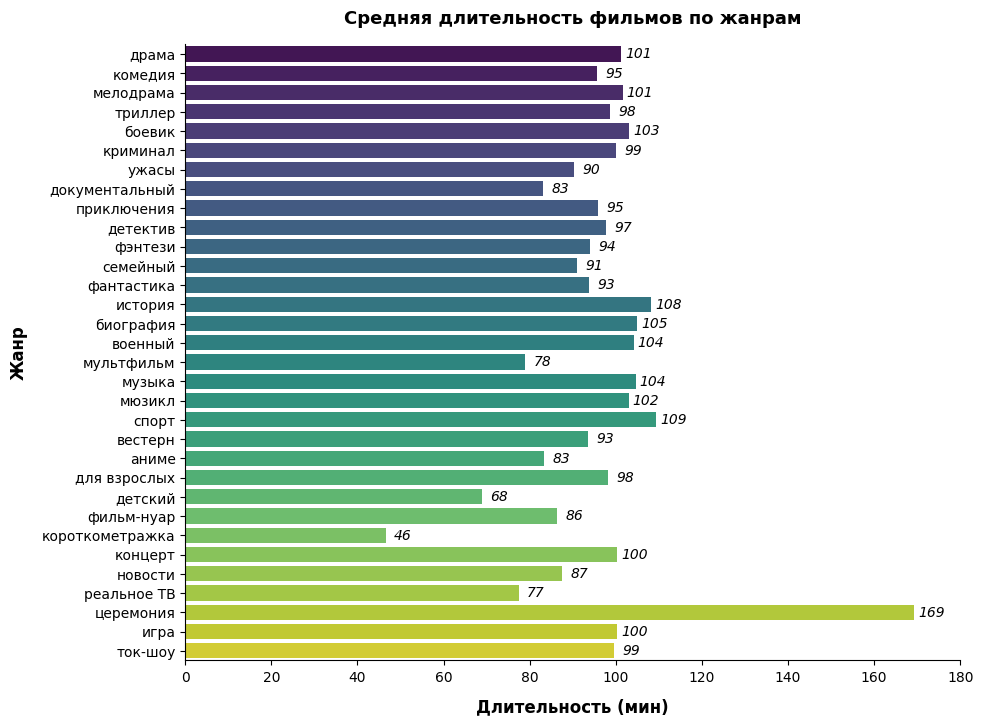

In [ ]:
genre_runtime = []
for _, row in movies_df.dropna(subset=['genres', 'runtime']).iterrows():
    for genre in row['genres']:
        genre_runtime.append({'genre': genre, 'runtime': row['runtime']})

genre_df = pd.DataFrame(genre_runtime)
genre_count = genre_df.groupby('genre').size().reset_index(name='count')
avg_runtime_per_genre = genre_df.groupby('genre')['runtime'].mean().reset_index()
avg_runtime_per_genre = pd.merge(avg_runtime_per_genre, genre_count, on='genre')
avg_runtime_per_genre = avg_runtime_per_genre.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(avg_runtime_per_genre, x='runtime', y='genre', palette='viridis', width=0.8)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_x() + p.get_width() + 4, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, fontstyle='italic')
plt.xlabel('Длительность (мин)', fontsize=12, fontweight='bold', labelpad=10)
plt.xlim(0, 180)
plt.ylabel('Жанр', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Средняя длительность фильмов по жанрам', fontsize=13, fontweight='bold', pad=15)
plt.show()

# Наиболее продолжительный по времени жанр - `церемонии`, например, церемонии вручения премии Оскар. Можно заметить,
# что много жанров не подходят под формат нашего проекта, поэтому некоторые из этих жанров в
# дальнейшем мы уберем, чтобы не рекомендовать их пользователям. Большинство жанров имеют примерно одинаковую продолжительность.
# Выбивается из общего тренда только короткометражки, но это оправданно их названием.

In [ ]:
movies_not_null = movies_df.dropna(subset=['genres', 'runtime'])

genres_contains_ceremony = movies_not_null[movies_not_null['genres'].apply(lambda x: 'церемония' in x)]
genres_contains_ceremony.sort_values(by='runtime', ascending=False)[['name', 'runtime']].head(10)

# Примеры фильмов из жанра церемонии

,name,runtime
878243,Премия Муз-ТВ 2011,290.0
873372,74-я церемония вручения премии «Оскар»,256.0
881138,79-я церемония вручения премии «Оскар»,232.0
859061,89-я церемония вручения премии «Оскар»,229.0
865476,76-я церемония вручения премии «Оскар»,225.0
875733,82-я церемония вручения премии «Оскар»,217.0
857075,67-я церемония вручения премии «Оскар»,215.0
864910,78-я церемония вручения премии «Оскар»,214.0
864886,81-я церемония вручения премии «Оскар»,210.0
863246,91-я церемония вручения премии «Оскар»,210.0


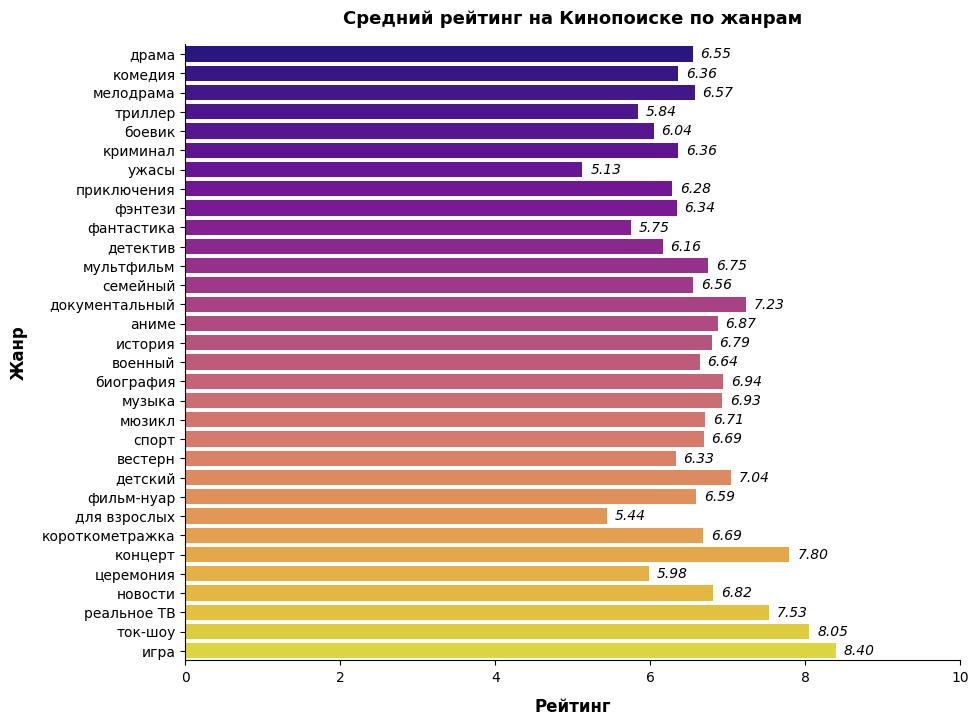

In [ ]:
genre_rating = []
for _, row in movies_df.dropna(subset=['genres', 'rating_kp']).iterrows():
    for genre in row['genres']:
        genre_rating.append({'genre': genre, 'kp': row['rating_kp']})

genre_df = pd.DataFrame(genre_rating)
genre_count = genre_df.groupby('genre').size().reset_index(name='count')
avg_rating_per_genre = genre_df.groupby('genre')['kp'].mean().reset_index()
avg_rating_per_genre = pd.merge(avg_rating_per_genre, genre_count, on='genre')
avg_rating_per_genre = avg_rating_per_genre.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(avg_rating_per_genre, x='kp', y='genre', palette='plasma', width=0.8)
sns.despine()
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}',
                (p.get_x() + p.get_width() + 0.3, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, fontstyle='italic')

plt.xlabel('Рейтинг', fontsize=12, fontweight='bold', labelpad=10)
plt.xlim(0, 10)
plt.ylabel('Жанр', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Средний рейтинг на Кинопоиске по жанрам', fontsize=13, fontweight='bold', pad=15)
plt.show()

# Самые большие рейтинги имеют шоу развлекательного формата. Это можно объянить тем, что фильмы такого жанра представлены
# в датасете в очень малом количестве. Как мы выяснили ранее, их мы из датасета уберем и не будем рекомендовать
# пользователям, сконцентрируемся только на фильмах. Жанр драма, количество которых, как мы выяснили ранее, наибольшее в нашей
# выборке, имеет средний рейтинг 6.55, что очень близко к среднему рейтингу всех фильмов в принципе.

In [ ]:
movies_not_null = movies_df.dropna(subset=['genres', 'rating_kp'])

genres_contains_game = movies_not_null[movies_not_null['genres'].apply(lambda x: 'игра' in x)]
genres_contains_game.sort_values(by='rating_kp', ascending=False)[['name', 'rating_kp']]

# Примеры фильмов из жанра игра с наибольшими рейтингами

,name,rating_kp
967414,Подземелья Чикен Карри-24. Черный Геленбург,9.1
971429,Подземелья Чикен Карри-28. Чёрное небо вампиров,9.0
913712,Подземелья Чикен Карри-20. Вампирское возмездие,8.9
965624,Подземелья Чикен Карри-22. Отряд Солнца,8.9
969257,Подземелья Чикен Карри-25. Остров соблазна,8.7
982535,Подземелья Чикен Карри-27. Достучаться до небес,8.2
950643,КиноКвиз. Культовые фильмы и сериалы,7.9
898454,Большая жирная викторина года 2015,7.7
943815,История одного турнира,7.2


## Текущие выводы

### Предобработка данных

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163964 entries, 0 to 989204
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   id                   163964 non-null  int64   
 1   type                 163964 non-null  object  
 2   name                 163964 non-null  object  
 3   release_year         163964 non-null  int64   
 4   description          117299 non-null  object  
 5   rating_kp            64601 non-null   float64 
 6   rating_imdb          147278 non-null  float64 
 7   runtime              153472 non-null  float64 
 8   age_rating           53480 non-null   float64 
 9   poster_url           163964 non-null  object  
 10  genres               162176 non-null  object  
 11  countries            163650 non-null  object  
 12  people               163364 non-null  object  
 13  description_len      163964 non-null  int64   
 14  description_len_bin  163964 non-null  category
dtypes: ca

In [ ]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344377 entries, 0 to 5909049
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   id         1344377 non-null  int64 
 1   name       1344377 non-null  object
 2   photo_url  285483 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.0+ MB


В результате проведения предобработки данных, в которой была отсеяна основная часть фильмов, мы сделали следующие действия:
* Взяли фильмы с только `русскими названиями`;
* Взяли фильмы, которые имеют дату выпуска и вышли до `2025 года`;
* Заменили значения рейтингов `0.0` => отсутствие рейтинга;
* Округлили значения рейтингов до десятых;
* Убрали фильмы короче `40` и длиннее `300` минут;
* Убрали все фильмы без постеров + изъяли общую часть URL-адреса;

Также мы поработали с данными по людям:
* Оставили только тех, кто есть в фильмах, оставшихся после предыдущей обработки;
* Удалили всех людей без имен + со значением `"Аноним"`;
* Убрали общую часть URL-адреса у фоток;

После такой обработки у нас осталось `163964` фильмов и `1344377` актеров и режиссеров, поучаствовавших в них.




### Выводы из статистического анализа

Итак, как мы выяснили ранее, данные имеют не полную заполненность по некоторым полям:
* Только `1/3` всех фильмов имеет возрастное ограничение;
* Некоторые фильмы не имеют продолжительности;
* Оценку на Кинопоиске имеют только `~64000` фильмов, а на IMDB - `~147000`;
* Около `117000` фильмов имеют описания;
* Небольшая часть фильмов имеет пропуски в столбцах с `жанрами`, `странами` и `составом людей`;

1) Стоит отметить, что **Кинопоиск** качественно заполняет карточки наиболее востребованных и популярных фильмов. Из этого можно сделать вывод, что фильмы без какого-либо поля либо не востребованы зрителями, либо попали под ошибку модерации. Но, опять же, **Кинопоиск** - крупнейший сервис с большой командой, контролирующей заполненность карточек, поэтому шанс механической ошибки в заполненности карточки очень мал.

2) Фильмы без указанного возрастного ограничения не являются большой проблемой, эти поля можно оставить пустыми, так как они не имеют сильного влияния на дальнейшую работу.

3) `description` - ключевой признак для дальнейшего обучения наших моделей, поэтому логично сделать вывод, что мы должны оставить только фильмы с описанием в дальнейшей работе.

In [ ]:
all_genres = []
for genres_list in movies_df['genres'].dropna():
    all_genres.extend(genres_list)

unique_genres = sorted(list(set(all_genres)))

np.array(unique_genres)

array(['аниме', 'биография', 'боевик', 'вестерн', 'военный', 'детектив',
       'детский', 'для взрослых', 'документальный', 'драма', 'игра',
       'история', 'комедия', 'концерт', 'короткометражка', 'криминал',
       'мелодрама', 'музыка', 'мультфильм', 'мюзикл', 'новости',
       'приключения', 'реальное ТВ', 'семейный', 'спорт', 'ток-шоу',
       'триллер', 'ужасы', 'фантастика', 'фильм-нуар', 'фэнтези',
       'церемония'], dtype='<U15')

Пожалуй, ключевой вывод после статистического анализа - **_выявление ряда жанров_**, которые `не подходят под формат` нашего приложения. Мы решили убрать следующие жанры:

* для взрослых;
* игра;
* концерт;
* короткометражка
* новости;
* ток-шоу;
* церемения;

Также одна из основных гипотез, выдвинутых на данном этапе, заключается в том, что наиболее релевантными для рекомендаций пользователю являются те фильмы, у которых все поля заполнены. Посмотрим сколько их.

In [ ]:
movies_df.dropna().shape[0]

34819

## Постобработка

Примерный план:
* Удалить с оценкой `ниже 4.5` и на Кинопоиске, и на imdb;
* Удалить фильмы с жанрами, указанными выше;
* Проверить наличие фильмов с названием `Untitled`;
* Убрать все фильмы без описания;
* Удалить с описанием `>=N` символов;

Также важно отметить, что карточки фильмов с полностью заполненнными полями имеют больший приоритет при рекомендациях. Нужно подумать над тем, как это учитывать.

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163964 entries, 0 to 989204
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   id                   163964 non-null  int64   
 1   type                 163964 non-null  object  
 2   name                 163964 non-null  object  
 3   release_year         163964 non-null  int64   
 4   description          117299 non-null  object  
 5   rating_kp            64601 non-null   float64 
 6   rating_imdb          147278 non-null  float64 
 7   runtime              153472 non-null  float64 
 8   age_rating           53480 non-null   float64 
 9   poster_url           163964 non-null  object  
 10  genres               162176 non-null  object  
 11  countries            163650 non-null  object  
 12  people               163364 non-null  object  
 13  description_len      163964 non-null  int64   
 14  description_len_bin  163964 non-null  category
dtypes: ca

In [ ]:
movies_df[movies_df['name'].str.contains('Untitled', case=False, na=False)]

,id,type,name,release_year,description,rating_kp,rating_imdb,runtime,age_rating,poster_url,genres,countries,people,description_len,description_len_bin


In [ ]:
movies_df.drop(columns=['description_len_bin'], inplace=True)
movies_df.dropna(subset=['description'], inplace=True)
movies_df = movies_df[movies_df['description_len'] <= 2000]
movies_df.drop(columns=['description_len'], inplace=True)
movies_df.shape

(117290, 13)

In [ ]:
movies_df = movies_df[movies_df['rating_kp'].notna() | movies_df['rating_imdb'].notna()]
movies_df = movies_df[(movies_df['rating_kp'] >= 4.5) | (movies_df['rating_imdb'] >= 4.5)]
movies_df.shape

(100304, 13)

In [ ]:
genres_to_remove = ['для взрослых', 'игра', 'концерт', 'короткометражка', 'новости', 'ток-шоу', 'церемония']

def remove_movies_with_genres(movies_df):
    movies_df = movies_df.copy()
    movies_df = movies_df[
        ~movies_df['genres'].apply(lambda x: any(genre in x for genre in genres_to_remove) if isinstance(x, list) else False)
    ]
    return movies_df


movies_df = remove_movies_with_genres(movies_df)
movies_df.shape

(99188, 13)

In [ ]:
people_df.head()

,id,name,photo_url
0,41644,Омар Си,/1777765/6ff214c8-e427-4dc2-b447-a1a51743c3ff/...
1,57174,Анн Ле Ни,/1704946/5a5a2bdf-6e96-47ed-9675-cb42c1712d3c/...
2,868557,Одри Флёро,/1777765/8cff3d96-7dd6-487b-a9df-537ff056e375/...
3,541041,Жозефин де Мо,/1777765/726cdd85-f2ca-4ff7-b7ee-5c28db8d1139/...
4,964574,Альба Гайя Крагеде Беллуджи,/4774061/8e98010f-0814-45e9-8c8a-6d9c968e412c/...


In [ ]:
all_people_ids = set()
for movie in movies_df['people']:
    if movie is np.nan or not isinstance(movie, list): continue
    all_people_ids.update([int(id) for id, _ in movie])

people_df = people_df[people_df['id'].isin(all_people_ids)]

#### Маппинг и сохранение на Google Диск

In [ ]:
movie_id_mapping = {old_id: new_id for new_id, old_id in enumerate(movies_df['id'], start=1)}
people_id_mapping = {old_id: new_id for new_id, old_id in enumerate(people_df['id'], start=1)}


def update_people_ids(people_list):
    if people_list is np.nan or not isinstance(people_list, list): return np.nan

    updated_list = []
    for old_id, prof in people_list:
        new_id = people_id_mapping[int(old_id)]
        updated_list.append((new_id, prof))
    return updated_list


movies_df['people'] = movies_df['people'].apply(update_people_ids)
movies_df = movies_df.reset_index(drop=True)
movies_df.drop(columns=['id'], inplace=True)

people_df = people_df.reset_index(drop=True)
people_df.drop(columns=['id'], inplace=True)


In [ ]:
# Create table `movie-roles`
movie_people_data = []

for movie_id, row in movies_df.iterrows():
    if row['people'] is np.nan or not isinstance(row['people'], list): continue

    people_dict = {}
    for person_id, role in row['people']:
        if person_id in people_dict:
            people_dict[person_id] = 'BOTH'
        else:
            people_dict[person_id] = 'ACTOR' if role[:-1] == 'актер' else 'DIRECTOR'

    # DIRECTOR (False, False) → BOTH (False, True) → ACTOR (True, False)
    sorted_people = sorted(people_dict.items(), key=lambda x: (x[-1] == 'ACTOR', x[-1] == 'BOTH'))

    for i, (person_id, role) in enumerate(sorted_people):
        movie_people_data.append({
            'movie_id': movie_id + 1,
            'person_id': person_id,
            'priority': i,
            'role': role
        })

movie_roles_df = pd.DataFrame(movie_people_data)
movies_df.drop(columns=['people'], inplace=True)

In [ ]:
movies_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99188 entries, 0 to 99187
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          99188 non-null  object 
 1   name          99188 non-null  object 
 2   release_year  99188 non-null  int64  
 3   description   99188 non-null  object 
 4   rating_kp     58572 non-null  float64
 5   rating_imdb   95420 non-null  float64
 6   runtime       95371 non-null  float64
 7   age_rating    42281 non-null  float64
 8   poster_url    99188 non-null  object 
 9   genres        98886 non-null  object 
 10  countries     99102 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 8.3+ MB


In [ ]:
people_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965682 entries, 0 to 965681
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   name       965682 non-null  object
 1   photo_url  243406 non-null  object
dtypes: object(2)
memory usage: 14.7+ MB


In [ ]:
movie_roles_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652671 entries, 0 to 2652670
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   movie_id   2652671 non-null  int64 
 1   person_id  2652671 non-null  int64 
 2   priority   2652671 non-null  int64 
 3   role       2652671 non-null  object
dtypes: int64(3), object(1)
memory usage: 81.0+ MB


In [ ]:
movies_df.head()

,type,name,release_year,description,rating_kp,rating_imdb,runtime,age_rating,poster_url,genres,countries
0,MOVIE,Девчата,1962,В сибирский поселок приехала юная повариха Тос...,8.5,7.8,92.0,0.0,/4303601/d5ee73ae-82af-4f60-af5e-f080bed523d8/...,"[мелодрама, комедия]",[СССР]
1,MOVIE,Зависнуть в Палм-Спрингс,2020,9 ноября неподалёку от Палм-Спрингс идёт подго...,7.3,7.4,90.0,18.0,/1898899/b1ed53cd-002f-419b-89bf-1eb66507f6de/...,"[комедия, мелодрама, фантастика]","[США, Гонконг]"
2,MOVIE,Форсаж,2001,"Его зовут Брайан, и он — фанат турбин и нитроу...",7.8,6.8,106.0,18.0,/6201401/8277905e-aa09-465d-b0de-7c389a42f215/...,"[боевик, триллер, криминал]","[США, Германия]"
3,CARTOON,Иван Царевич и Серый Волк 5,2022,"Была у Ивана с Василисой не жизнь, а сказка. Б...",7.4,NaN,78.0,6.0,/6201401/36116ce0-2960-4713-9410-8e41055c7b1c/...,"[мультфильм, приключения, семейный]",[Россия]
4,MOVIE,Дело храбрых,2017,История о команде пожарных под названием Grani...,8.3,7.6,134.0,18.0,/1946459/946e69f2-80eb-41c1-b1cd-695a4644be55/...,"[драма, триллер, биография, история]",[США]


In [ ]:
people_df.head()

,name,photo_url
0,Омар Си,/1777765/6ff214c8-e427-4dc2-b447-a1a51743c3ff/...
1,Анн Ле Ни,/1704946/5a5a2bdf-6e96-47ed-9675-cb42c1712d3c/...
2,Одри Флёро,/1777765/8cff3d96-7dd6-487b-a9df-537ff056e375/...
3,Жозефин де Мо,/1777765/726cdd85-f2ca-4ff7-b7ee-5c28db8d1139/...
4,Альба Гайя Крагеде Беллуджи,/4774061/8e98010f-0814-45e9-8c8a-6d9c968e412c/...


In [ ]:
movie_roles_df.head()

,movie_id,person_id,priority,role
0,1,770161,0,DIRECTOR
1,1,771344,1,ACTOR
2,1,259,2,ACTOR
3,1,764784,3,ACTOR
4,1,770729,4,ACTOR


In [ ]:
# Сохранение таблиц в формат pickle
movies_df.to_pickle("movies.pkl")
people_df.to_pickle("people.pkl")
movie_roles_df.to_pickle("movie_roles.pkl")

# Сохранение на google диск
!mkdir /content/drive/MyDrive/processed_dataset/
!cp movies.pkl /content/drive/MyDrive/processed_dataset/
!cp people.pkl /content/drive/MyDrive/processed_dataset/
!cp movie_roles.pkl /content/drive/MyDrive/processed_dataset/

In [ ]:
# Cохранение маппинга для дальнейших изменений/действий
mapping_data = {
    "movie_id_mapping": movie_id_mapping,
    "people_id_mapping": people_id_mapping
}

with open("id_mapping.json", "w") as f:
    json.dump(mapping_data, f)

!cp id_mapping.json /content/drive/MyDrive/processed_dataset/

Итого осталось `99188` фильмов и `965682` актёров и режиссёров вместе взятых